In [165]:
import os
from glob import glob
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
import tensorflow.python.keras.backend as K
from imblearn.over_sampling import SMOTE
from keras import Input, Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import (Activation, Add, AveragePooling2D,
                          BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          GlobalAveragePooling2D, MaxPool2D, MaxPooling2D,
                          ZeroPadding2D, concatenate)
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.python.ops.state_ops import scatter_nd_sub
import random
import cv2
import os
from keras.regularizers import L2
from keras.utils import load_img

In [70]:
print("Available devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [71]:
NUM_CLASSES = 8
INPUT_SHAPE = (75, 100, 1)

Read Meta Data

In [72]:
skin_df =  pd.read_csv('./dcnn-dataset/skin-lesion/HAM10000_metadata.csv')
print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


Load Data

In [73]:

# Preprocess Data
paths = {}

# Get a dictionary filled with all image Ids, and their path
for x in glob(os.path.join("./dcnn-dataset/skin-lesion/", "*", "*.jpg")):
    paths[os.path.splitext(os.path.basename(x))[0]] = x

skin_df['path'] = skin_df['image_id'].map(paths.get)

# Get the legible lesion type from the symbol
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma',
    "clr": "Clear Skin"
}

skin_df['cell_type'] = skin_df['dx'].map(lesion_type.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['image'] = skin_df['path'].map(lambda image: np.asarray(Image.open(image).resize((100, 75))))


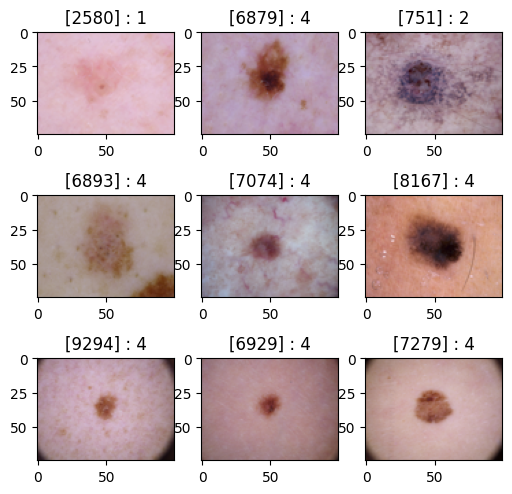

In [74]:

plt.figure(figsize=(6, 6))
for i in range(9):
  random_index = random.randint(0, len(skin_df) - 1)
  img = skin_df.loc[random_index, 'image']
  title = skin_df.loc[random_index, 'cell_type_idx']
  plt.subplot(3, 3, i + 1)
  plt.title(f'[{random_index}] : {title}')
  plt.imshow(img, cmap='gray')

Load Normal Data

In [75]:

print("Loading Normal Clear Skin Dataset")

clear_skin_image_list = []

for filename in os.listdir("./dcnn-dataset/normal-skin"):
    path = "./dcnn-dataset/normal-skin/" + filename
    clear_skin_image_list.append(np.asarray(Image.open(path).resize((100, 75))))

image_series = pd.Series(clear_skin_image_list, name='image')

skin_df = pd.concat([skin_df, pd.DataFrame({"image": image_series, 'cell_type_idx': 7})], ignore_index=True)


Loading Normal Clear Skin Dataset


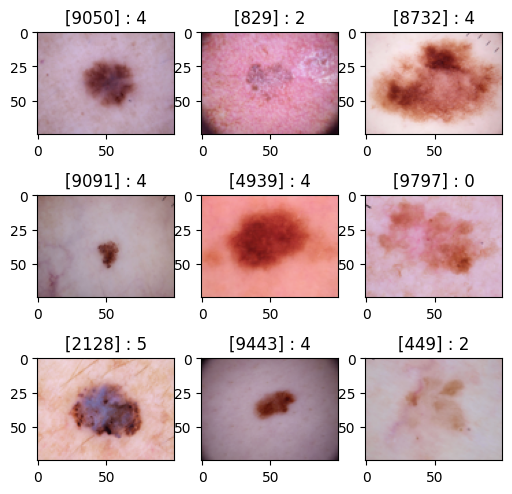

In [82]:

plt.figure(figsize=(6, 6))
for i in range(9):
  random_index = random.randint(0, len(skin_df) - 1)
  img = skin_df.loc[random_index, 'image']
  title = skin_df.loc[random_index, 'cell_type_idx']
  plt.subplot(3, 3, i + 1)
  plt.title(f'[{random_index}] : {title}')
  plt.imshow(img)

Image processing

In [186]:
features = skin_df["image"]
target = skin_df["cell_type_idx"]

In [187]:
features = np.asarray(features.tolist())
# feature_mean = np.mean(features)
# feature_std = np.std(features)
# print("Mean: ", feature_mean)
# print("Std: ", feature_std)
# features = (features - feature_mean) / feature_std
features = [cv2.cvtColor(feature, cv2.COLOR_BGR2GRAY) for feature in features]
features = [cv2.equalizeHist(feature) for feature in features]

features = np.array(features).astype('float64')
features /= 255

# Blue starts here
# plt.imshow((features[0]).astype('uint8'))
# plt.title("Normalized Image")
# plt.show()

# One Hot Encoder
target = to_categorical(target, num_classes=NUM_CLASSES)

# Reshape image to 3 dimension (75 * 100 * 3)
features = features.reshape(features.shape[0], *INPUT_SHAPE)

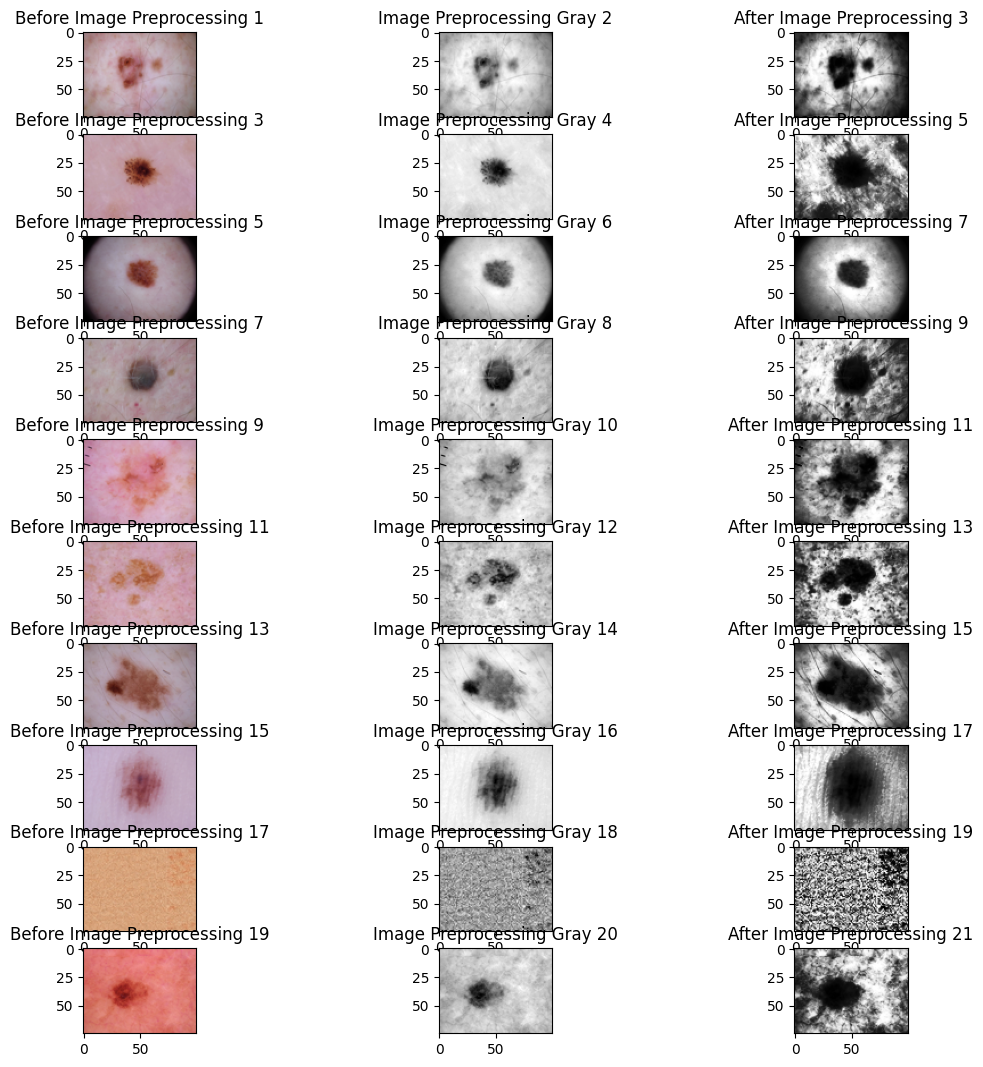

In [141]:
tests = skin_df['image']

random_len = 10
plt.figure(figsize=(13, 13))
for i in range(random_len):
  j = random.randint(0, len(skin_df))
  t_feature = tests[j]
  t_feature = np.array(t_feature)

  t_feature_gray = cv2.cvtColor(t_feature, cv2.COLOR_BGR2GRAY)
  t_feature = cv2.equalizeHist(t_feature_gray)

  # t_feature = (t_feature- feature_mean) / feature_std
  t_feature = t_feature.astype('float64')
  t_feature /= 255

  plt.subplot(random_len, 3, i * 3 + 1)
  plt.title(f'Before Image Preprocessing {i * 2 + 1}')
  plt.imshow(tests[j], cmap='gray')

  plt.subplot(random_len, 3, i * 3 + 2)
  plt.title(f'Image Preprocessing Gray {i * 2 + 2}')
  plt.imshow(t_feature_gray, cmap='gray')

  plt.subplot(random_len, 3, i * 3 + 3)
  plt.title(f'After Image Preprocessing { i * 2 + 3}')
  plt.imshow(t_feature, cmap='gray')

In [142]:
# Check Normalization
print(features[0])

[[[0.35686275]
  [0.39607843]
  [0.37647059]
  ...
  [0.21176471]
  [0.21176471]
  [0.29019608]]

 [[0.2745098 ]
  [0.29019608]
  [0.37647059]
  ...
  [0.21176471]
  [0.2       ]
  [0.23529412]]

 [[0.3372549 ]
  [0.35686275]
  [0.44313725]
  ...
  [0.18431373]
  [0.15294118]
  [0.1254902 ]]

 ...

 [[0.1254902 ]
  [0.17254902]
  [0.22352941]
  ...
  [0.32156863]
  [0.29019608]
  [0.2627451 ]]

 [[0.08627451]
  [0.12156863]
  [0.14509804]
  ...
  [0.24705882]
  [0.24705882]
  [0.2       ]]

 [[0.05490196]
  [0.0627451 ]
  [0.06666667]
  ...
  [0.3372549 ]
  [0.3372549 ]
  [0.2       ]]]


In [ ]:
def check_image(features):
  for i in range(9):
    random_index = random.randint(0, len(features) - 1)
    img = features[random_index]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)

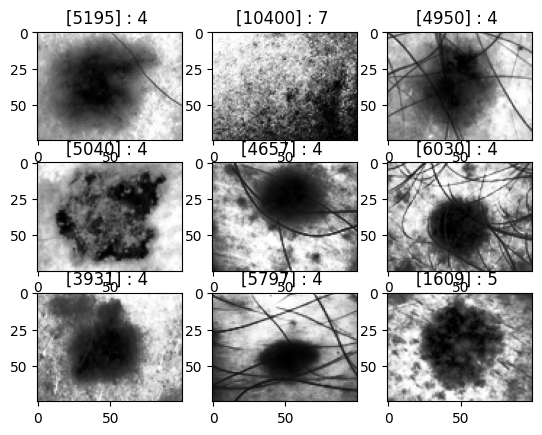

In [143]:
for i in range(9):
  random_index = random.randint(0, len(features) - 1)
  img = features[random_index]
  title = skin_df.loc[random_index, 'cell_type_idx']
  plt.subplot(3, 3, i + 1)
  plt.title(f'[{random_index}] : {title} ')
  plt.imshow(img, cmap='gray')

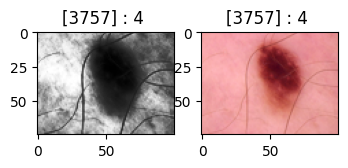

In [153]:

plt.figure(figsize=(6, 6))
random_index =random.randint(0, len(features) - 1)
img = features[random_index]
real_image = skin_df.loc[random_index, 'image']
title = skin_df.loc[random_index, 'cell_type_idx']

plt.subplot(3, 3, 1)
plt.title(f'[{random_index}] : {title} ')
plt.imshow(img, cmap='gray')


plt.subplot(3, 3, 2)
plt.title(f'[{random_index}] : {title} ')
plt.imshow(real_image)

Smote

In [188]:
rus = SMOTE(random_state=42)
features, target = rus.fit_resample(features.reshape(-1, INPUT_SHAPE[0] * INPUT_SHAPE[1]),
                                    target)
features = features.reshape(-1, *INPUT_SHAPE)

Split Image

In [189]:
x_train, x_temp, y_train, y_temp = train_test_split(features, target, test_size=0.35, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(x_test), len(x_test))

34866 9387 9387


In [185]:
def make_model():
    model = ResNet_18()
    # optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    model.build(input_shape=(None, *INPUT_SHAPE))
    return model

def residual_block( x, filters, down_sample=None, regularizer=None):
    x_shortcut = x
    if down_sample:
        stride = 2  # The more stride, the smaller the picture
        x_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)
    else:
        stride = 1

    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same',  kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)

    x = Add()([x_shortcut, x])
    x = Activation('relu')(x)
    return x
    
def ResNet_18():
    x_input = Input(INPUT_SHAPE)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding="same")(x_input)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, down_sample=True)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, down_sample=True, regularizer=L2(0.001))
    x = residual_block(x, filters=256)
    x = Dropout(0.5)(x)

    x = residual_block(x, filters=512, down_sample=True, regularizer=L2(0.001))
    x = residual_block(x, filters=512)
    x = Dropout(0.5)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x)
    return model

model = make_model()

In [190]:
# Last Image Pre Processing

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

datagen.fit(x_train)

7


Show augmented images

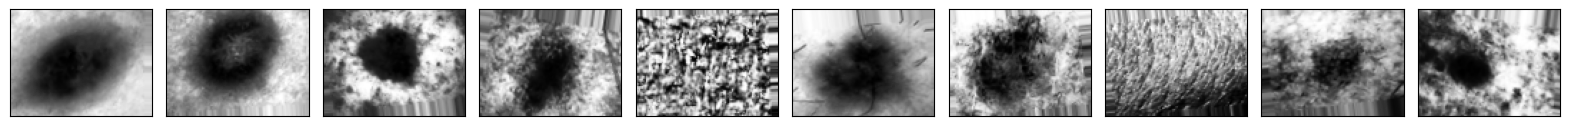

In [191]:
augmented_images, _ = next(datagen.flow(x_train, y_train, batch_size=10))

fig, axes = plt.subplots(1, 10, figsize=(20, 20),
                          subplot_kw={'xticks': [], 'yticks': []},
                          gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.clip(np.squeeze(augmented_images[i]), 0, 255), cmap='gray')

In [192]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            learning_rate=0.00001)


# plt.show()
print('Fitting Model ...')

# Fitting the model
epochs = 200
batch_size = 32
history = model.fit(datagen.flow(x_train, y_train, batch_size), 
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    steps_per_epoch=x_train.shape[0] // batch_size , 
                    callbacks=[learning_rate_reduction])


Fitting Model ...
Epoch 1/200
1089/1089 [==============================] - 42s 34ms/step - loss: 2.0167 - accuracy: 0.4469 - val_loss: 2.6340 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/200
1089/1089 [==============================] - 49s 45ms/step - loss: 1.3207 - accuracy: 0.5460 - val_loss: 2.0782 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 3/200
1089/1089 [==============================] - 49s 45ms/step - loss: 1.1635 - accuracy: 0.5977 - val_loss: 2.7428 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 4/200
1089/1089 [==============================] - 48s 44ms/step - loss: 1.0209 - accuracy: 0.6477 - val_loss: 1.4191 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 5/200
1089/1089 [==============================] - 48s 44ms/step - loss: 0.9229 - accuracy: 0.6898 - val_loss: 2.6397 - val_accuracy: 0.3614 - lr: 0.0010
Epoch 6/200
1089/1089 [==============================] - 51s 46ms/step - loss: 0.8160 - accuracy: 0.7274 - val_loss: 1.1416 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 7/200
1089/1089 

Evaluation

In [193]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
# self.print_confusion_matrix(model, x_test, y_test)

294/294 [==============================] - 3s 10ms/step - loss: 0.1328 - accuracy: 0.9641
Validation: accuracy = 0.964099  ;  loss_v = 0.132812
Test: accuracy = 0.961756  ;  loss = 0.141048


1/1 [==============================] - 0s 28ms/step


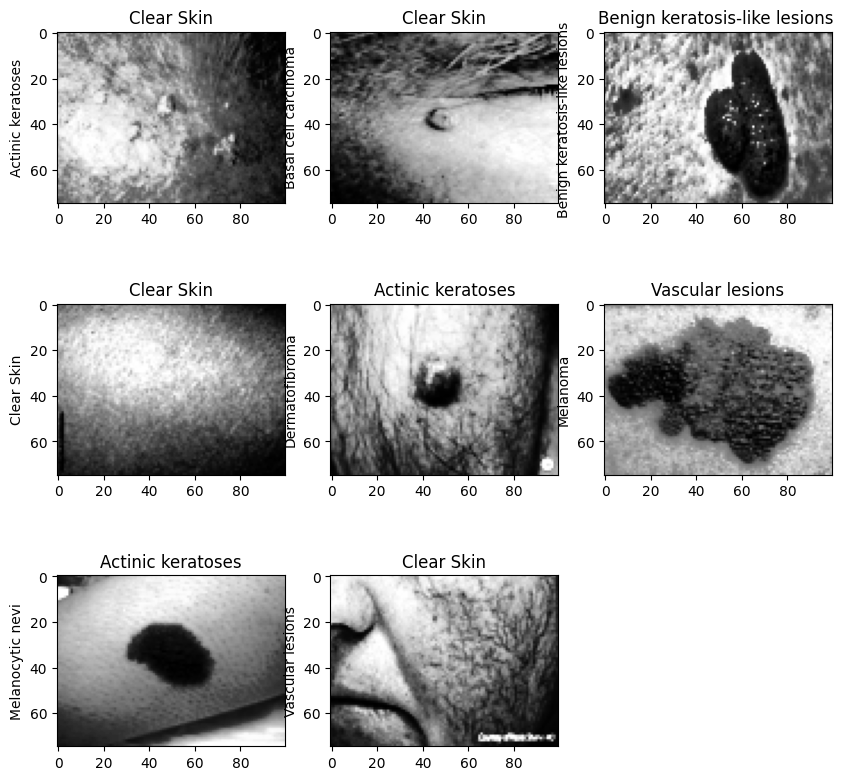

In [194]:
single_path = './dcnn-dataset/single'
single_names = [name for name in os.listdir(single_path)]
plt.figure(figsize=(10, 10))

lesion_list = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma',
    'Clear Skin'
]

def datagen_input_image(input_image):
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
    )
    datagen.fit(input_image)
    augmented_iterator = datagen.flow(input_image, batch_size=1)
    augmented_image = next(augmented_iterator)[0]
    # plt.imshow(np.clip(np.squeeze(augmented_image), 0, 255), cmap='gray')
    # plt.show()

    return augmented_image
  
for i, name in enumerate(single_names):
  img = Image.open('./dcnn-dataset/single/' + name)
  img = np.array(img.resize((100, 75)))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = np.array(img).astype('float64')
  img /= 255
  img = img.reshape(1, 75, 100, 1)
  img = datagen_input_image(img)
  
  lesion_name = name.split('.')[0]

  val = model.predict(np.expand_dims(img, axis=0), verbose=1)
  res_idx = np.argmax(val)
  plt.subplot(3, 3, i + 1)
  plt.title(lesion_list[res_idx])
  plt.ylabel(lesion_type.get(lesion_name))
  plt.imshow(img, cmap='gray')

In [195]:
model.save("model/dcnn-jt-2.h5", save_format="h5")

Print Confusion Matrix

In [ ]:
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.savefig('./report/dcnn-confusion.jpg')

lesion_list = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f", annot_kws={'size': 16}, annot=True, square=True,
                  xticklabels=lesion_type, yticklabels=lesion_type)  # What should I put here as a label
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

Plot Result

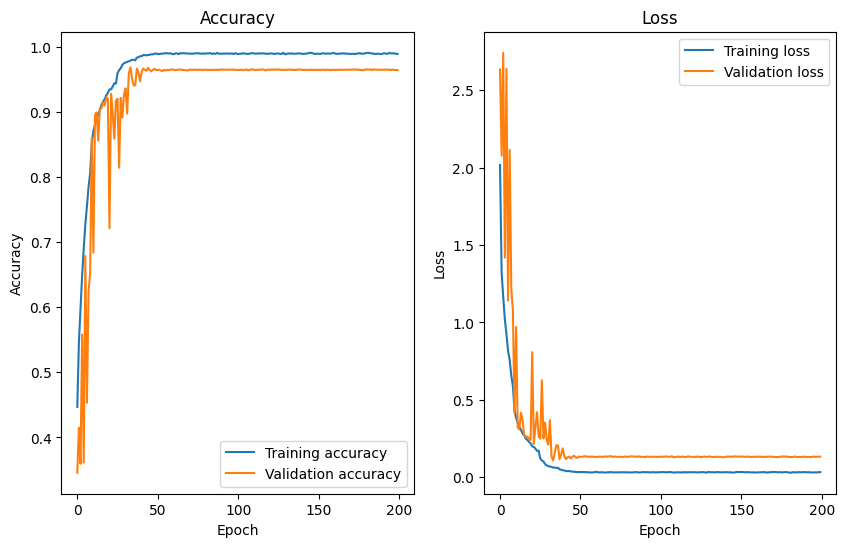

In [196]:
# Plot accuracy and loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")

plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")

plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Accuracy and Loss graph Perceptron.png")
plt.show()

Predict Image Processing

In [ ]:

# def get_external_image(url):
#     response = requests.get(url)
#     return response.content

# image_path = ''

# # img = Image.open('./dcnn-dataset/single/1.jpg')
# # img = Image.open(image_path)
# # img = img.resize((100, 75))
# # img = np.asarray(img)  # Convert image to numpy array
# # img = (img - feature_mean) / feature_std  # Normalize the image

# # # Blue starts here
# # plt.imshow((img).astype('uint8'))
# # plt.title("Normalized Image") 
# # plt.show()

# img = img.reshape(1, 75, 100, 3)  # Reshape to match model's input shape

# def datagen_input_image(input_image):
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#     )

#     datagen.fit(input_image)
#     augmented_iterator = datagen.flow(input_image, batch_size=1)
#     augmented_image = next(augmented_iterator)[0]
#     # plt.imshow(np.clip(np.squeeze(augmented_image), 0, 255), cmap='gray')
#     # plt.show()

#     return augmented_image